In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import time
import random
%matplotlib inline
#%matplotlib notebook
plt.style.use('ggplot')

In [2]:
#see all available columns
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

ejections = pd.read_csv('../data/ejections.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

Text(0, 0.5, 'Height of Pitch')

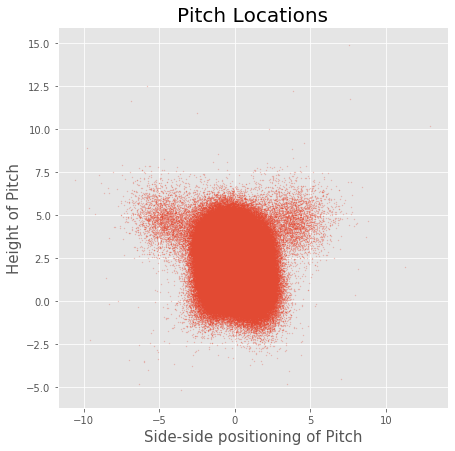

In [3]:
#plots pitch locations
plt.figure(figsize=(7,7))
plt.scatter(pitches['px'].values, pitches['pz'].values, alpha=0.2, s=1)
plt.title('Pitch Locations', size=20)
plt.xlabel('Side-side positioning of Pitch', size=15)
plt.ylabel('Height of Pitch', size=15)

In [4]:
pitches.shape

(2867154, 40)

In [5]:
atbats.shape

(740389, 11)

In [6]:
names.shape

(2218, 3)

In [7]:
ejections.shape

(761, 10)

In [8]:
games.shape

(9718, 17)

In [9]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)
pitches.reset_index(inplace=True)
#finds 'UN' in pitches and drops those rows
unknown_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(unknown_mask, inplace=True)

pitches['pitch_type'].replace('PO', 'FO', inplace=True)

In [10]:
#19,000 total rows that have atleast one NaN in them
rows_with_nans.shape

(19904,)

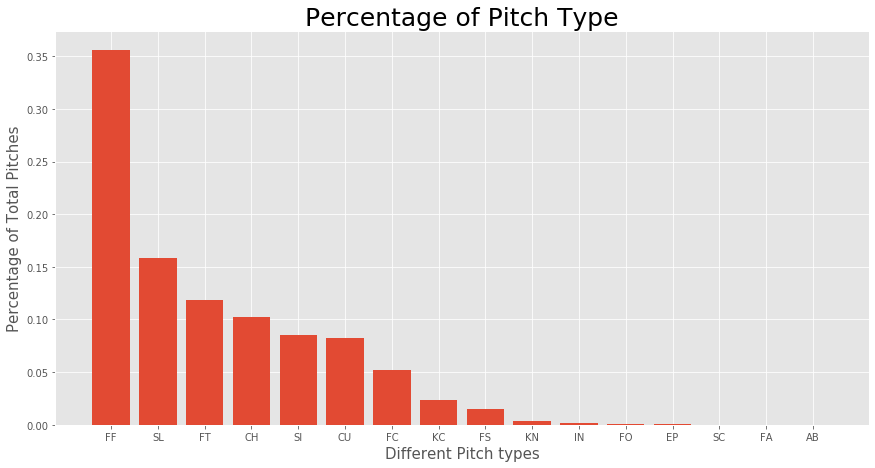

In [11]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[::-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1]
plt.figure(figsize=(12,6))
plt.bar(pitch, x/np.sum(x))
plt.tight_layout()
plt.title('Percentage of Pitch Type', size=25)
plt.ylabel('Percentage of Total Pitches', size=15)
plt.xlabel('Different Pitch types', size=15)
plt.savefig('../Graphics/pitch_types.png', dpi=100)

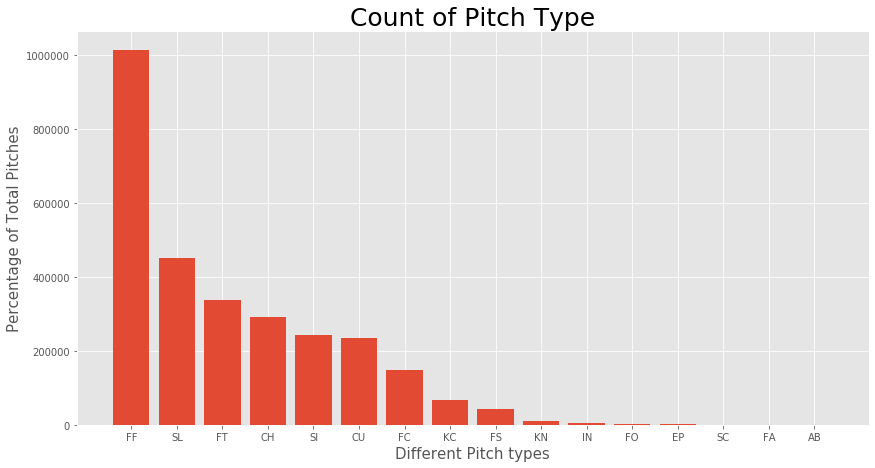

In [12]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[::-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1]
plt.figure(figsize=(12,6))
plt.bar(pitch, x)
plt.tight_layout()
plt.title('Count of Pitch Type', size=25)
plt.ylabel('Percentage of Total Pitches', size=15)
plt.xlabel('Different Pitch types', size=15)
plt.savefig('../Graphics/pitch_types_count.png', dpi=100)

In [13]:
#pca need to plot these compositions with every different pitch type and look to see a difference
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(pitches.iloc[:, :8])

In [14]:
#top 6 most common pitches
top_6_labels = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1][:6]

#first feature of pca with 2 components
x = pca_comps[:, 0]
#second feature of pac with 2 components
y = pca_comps[:, 1]
#labels of each pitch type for each row in pitches
pitch_type = pitches['pitch_type'].values

Plot took 5.386953830718994 to show


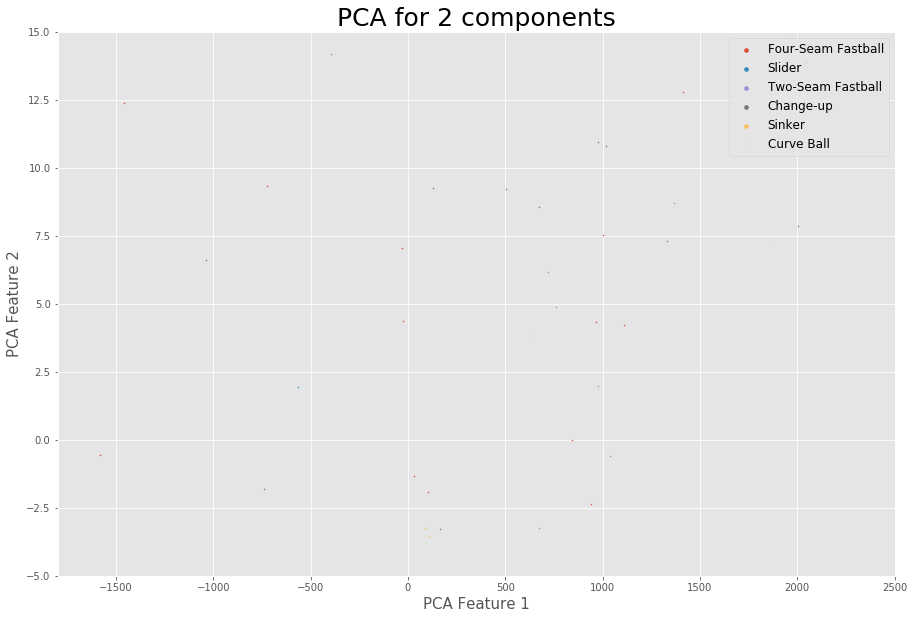

In [15]:
#grabs current time
current = time.time()
#dictionary to have nice plotting of types of pitches
dic = {'FF':'Four-Seam Fastball', 'SL': 'Slider', 'FT': 'Two-Seam Fastball', 'CH': 'Change-up', 'SI': 'Sinker', 'CU': 'Curve Ball'}


plt.figure(figsize=(15,10))
for label in top_6_labels:
    line = plt.scatter(x[pitch_type == label], y[pitch_type == label], label=label, s=1)
plt.title('PCA for 2 components', size=25)
line.set_alpha(0.02)
plt.xlabel('PCA Feature 1', size=15)
plt.ylabel('PCA Feature 2', size=15)
plt.ylim(-5, 15)
plt.xlim(-1800, 2500)
#plt.legend doesnt want to work??
plt.legend(loc=1, markerscale=4, fontsize='large', labels=dic.values())
plt.savefig('../Graphics/PCA_2comps.png', dpi=100);
print('Plot took {} to show'.format(time.time() - current))

## Takeaways from EDA
Predicting the pitch type based on the count, the pitcher, (the previous pitches??), the score, runners on 1st, 2nd, 3rd, the number of pitches thrown so far, pitcher left handed/right handed, the batter handedness, inning, so much more...

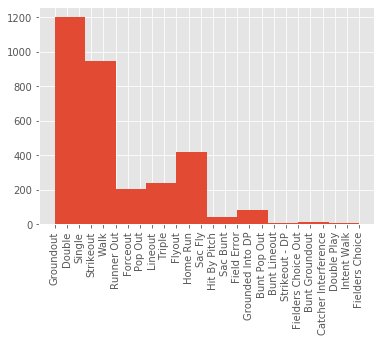

In [16]:
atbats[(atbats['pitcher_id'] == 452657)]['event'].hist()
plt.xticks(rotation=90);

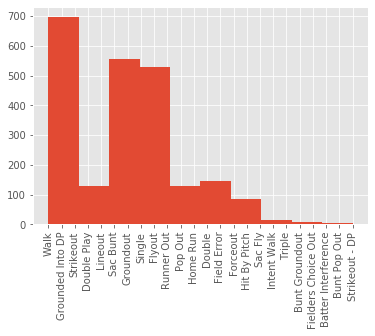

In [17]:
atbats[(atbats['pitcher_id'] == 448802)]['event'].hist()
plt.xticks(rotation=90);

In [18]:
#this pitcher has seen every batter on average of 6 times each 
atbats[(atbats['pitcher_id'] == 452657)] .groupby(['pitcher_id', 'batter_id']).count().mean()

ab_id       6.203523
event       6.203523
g_id        6.203523
inning      6.203523
o           6.203523
p_score     6.203523
p_throws    6.203523
stand       6.203523
top         6.203523
dtype: float64

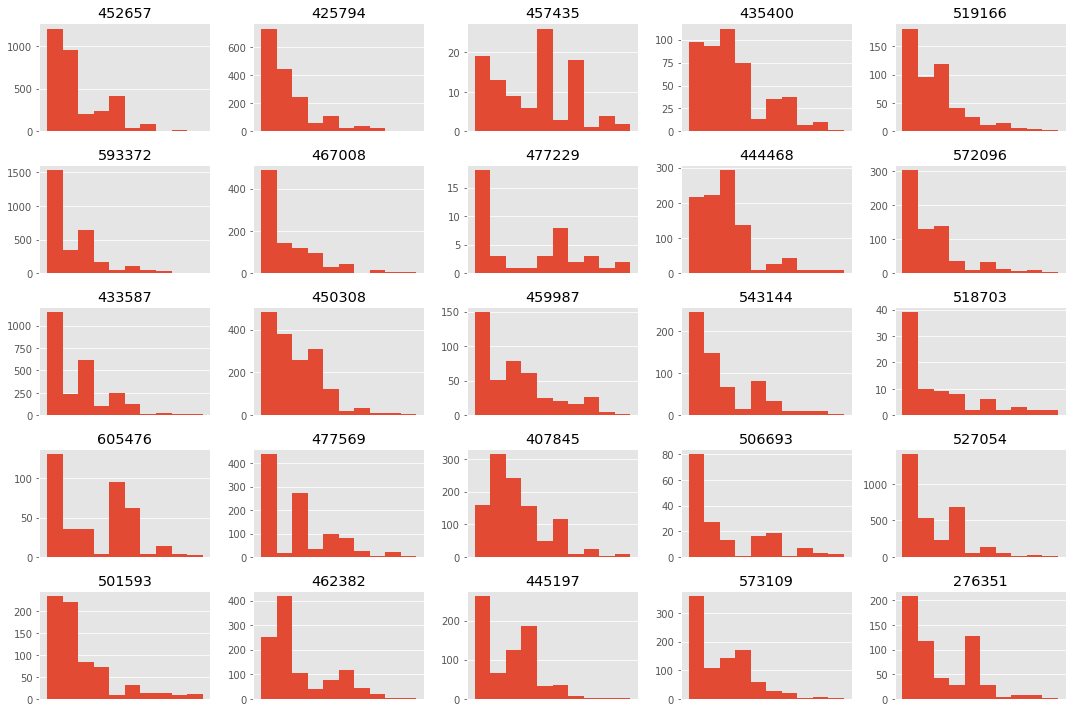

In [19]:
#looks at different pitchers and the results of all of the batters they see
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(atbats[atbats['pitcher_id'] == pitcher]['event'].values)
    ax.set_xticks([])
    ax.set_title(pitcher)
    
plt.tight_layout()
    

In [20]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

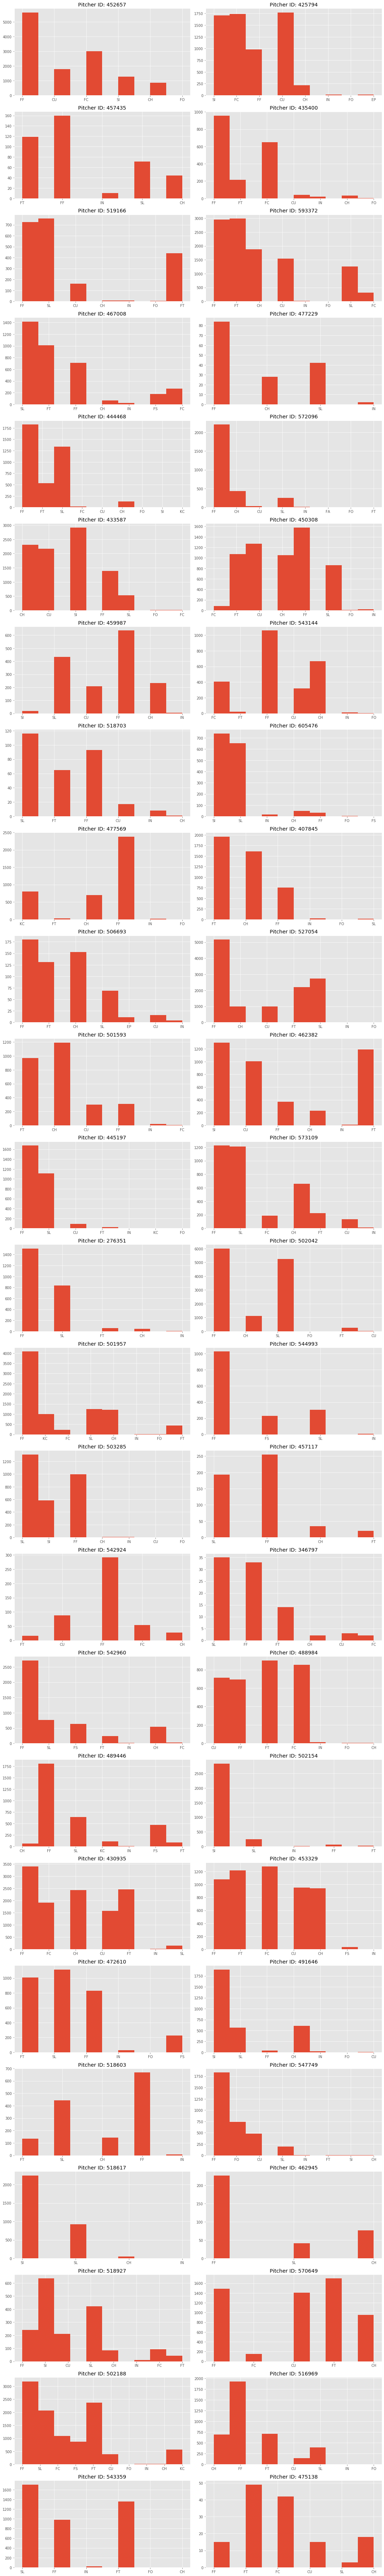

In [21]:
#looks at first 50 pitchers and observes their pitch types
fig, ax = plt.subplots(25, 2, figsize=(15, 100))
no_nan_df = game_sit.replace(np.nan, 'None')
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(no_nan_df[no_nan_df['pitcher_id'] == pitcher]['pitch_type'])
    #ax.set_xticks()
    ax.set_title('Pitcher ID: {}'.format(pitcher))
    
plt.tight_layout() 

Text(0, 0.5, 'Number of Pitches')

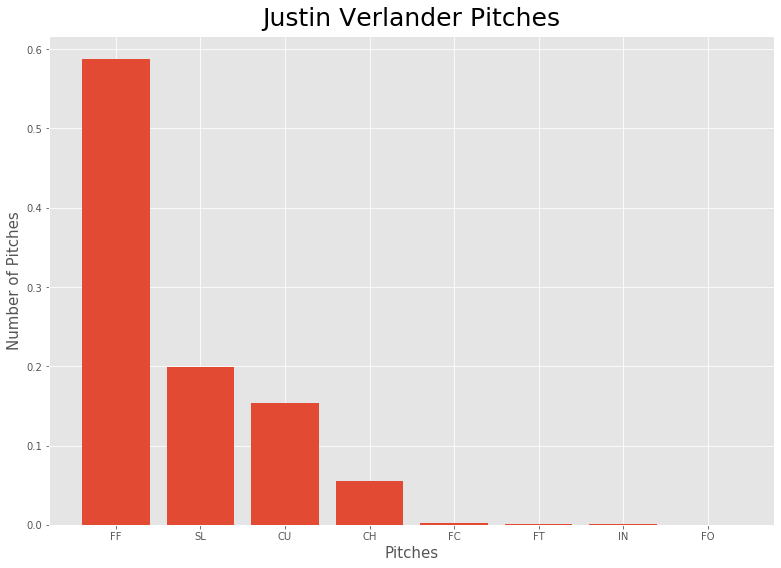

In [22]:
#looks at one pitchers distribution of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums/np.sum(nums))
plt.title('Justin Verlander Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Number of Pitches', size=15)
#plt.savefig('../Graphics/Verlander_pitches.png', dpi=100);

Text(0, 0.5, 'Percent of Total Pitches')

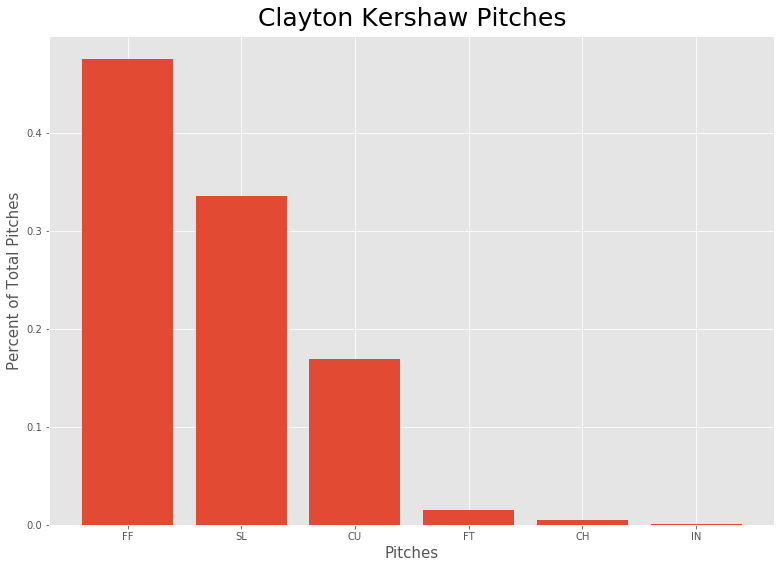

In [23]:
#Kershaw pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums / np.sum(nums))
plt.title('Clayton Kershaw Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Percent of Total Pitches', size=15)
#plt.savefig('../Graphics/Kershaw_pitches.png', dpi=100);

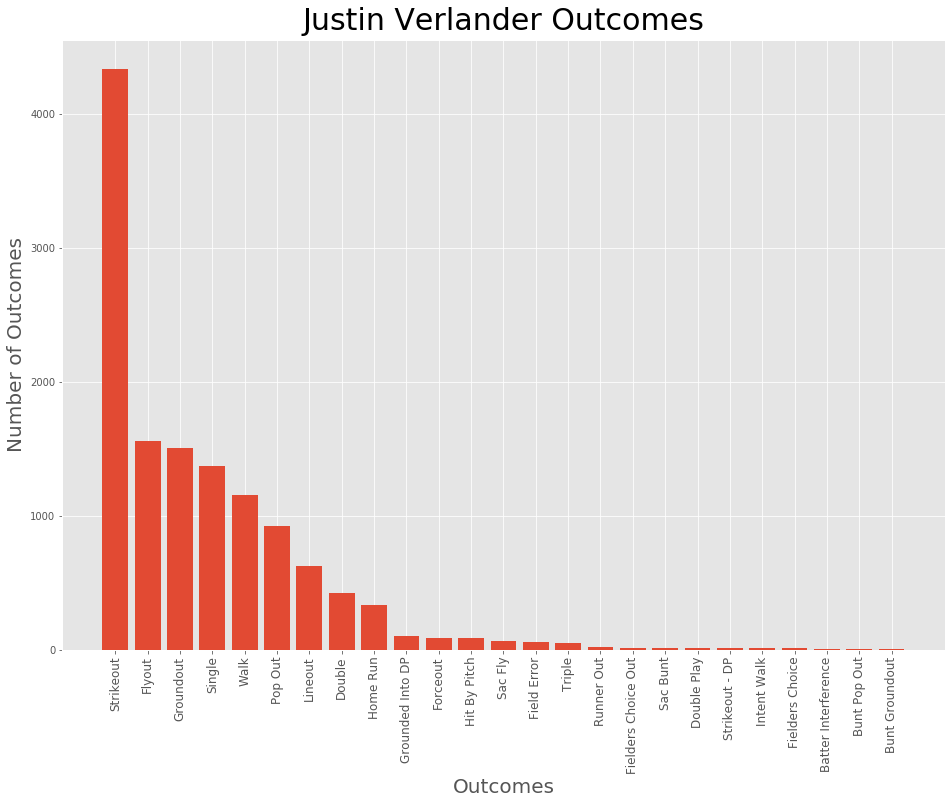

In [24]:
#distribution of outcomes of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].values
outcome = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].index

plt.figure(figsize=(13,9))
plt.bar(outcome, nums)
plt.tight_layout()
plt.ylabel('Number of Outcomes', size=20)
plt.xlabel('Outcomes', size=20)
plt.title('Justin Verlander Outcomes', size=30, pad=10)
plt.xticks(rotation=90, size=12);


In [25]:
#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [26]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

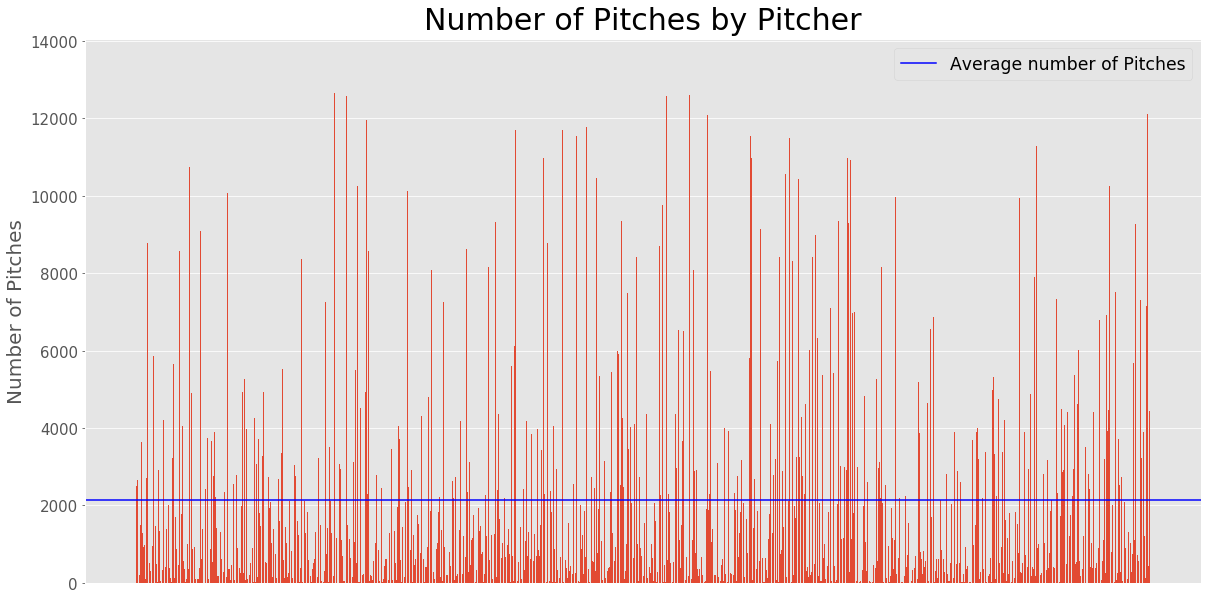

In [27]:

index = final_play_df.groupby('pitcher_name').count().iloc[:, 0].index
nums = final_play_df.groupby('pitcher_name').count().iloc[:, 0].values
mean_nums = np.mean(nums)

plt.figure(figsize=(20,10))
plt.title('Number of Pitches by Pitcher', size=30, pad=10)
plt.bar(index, nums)
plt.axhline(mean_nums, c='b', label='Average number of Pitches')
plt.xticks([])
plt.yticks(size=15)
plt.ylabel('Number of Pitches', size=20)
plt.legend(fontsize='xx-large');

In [28]:
final_play_df['pitcher_name'].unique()

array(['Adam Wainwright', 'Mike Leake', 'Andrew Cashner', ...,
       'Alexi Amarista', 'Danny Valencia', 'Rob Brantly'], dtype=object)

In [29]:
final_play_df

,pitcher_name,batter_name,ab_id,batter_id,pitcher_id,game_id,inning,p_score,p_throws,batter_stand,top,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch_type
0,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,FC
1,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,FC
2,Adam Wainwright,Jon Lester,2015000019,452657,425794,201500001,2,2,1,0,False,0.0,0.0,2.0,2.0,3.0,0.0,0.0,1.0,FF
3,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,FC
4,Adam Wainwright,Jon Lester,2017111163,452657,425794,201701451,3,0,1,0,False,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847188,Rob Brantly,Bradley Zimmer,2017160269,605548,542963,201702093,9,2,1,0,True,10.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,CU
2847189,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,CU
2847190,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,CU
2847191,Rob Brantly,Greg Allen,2017160272,656185,542963,201702093,9,2,1,0,True,11.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,CU


In [30]:
pitch_names = pd.get_dummies(final_play_df['pitcher_name'])

In [31]:
#takes a long time to run
#merges class_modeling with the new pitch names, drops the redundant columns 
#drops one of the pitchers from the df using random.choice 
df = final_play_df.merge(pitch_names, left_index=True, right_index=True).drop(columns=['ab_id', 'pitcher_name', 'batter_name', 'batter_id', 'pitcher_id', 'game_id', random.choice(pitch_names.columns)])

## Sampling each class 

Need to sample each pitch type of only 200,000 samples each. 

In [39]:
def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    #f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        acc_scores.append(model.score(X_test, y_test))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))

    #print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return np.mean(acc_scores) 

In [33]:
#moving to Logistic regression for base model
from sklearn.linear_model import LogisticRegression

### Pitches that have over 200,000 are:

FF

SL

FT

CH

SI

CU

In [34]:
ff = np.where(df['pitch_type'] == 'FF')[0]
sl = np.where(df['pitch_type'] == 'SL')[0]
ft = np.where(df['pitch_type'] == 'FT')[0]
ch = np.where(df['pitch_type'] == 'CH')[0]
si = np.where(df['pitch_type'] == 'SI')[0]
cu = np.where(df['pitch_type'] == 'CU')[0]


In [35]:
ff_index = random.choices(ff, k=200000)
sl_index = random.choices(sl, k=200000)
ft_index = random.choices(ft, k=200000)
ch_index = random.choices(ch, k=200000)
si_index = random.choices(si, k=200000)
cu_index = random.choices(cu, k=200000)

In [57]:
all_indicies = np.append([ff_index, sl_index, ch_index, si_index, cu_index], ft_index)

In [63]:
resampled_df = df.iloc[all_indicies, :]

In [64]:
resampled_df.reset_index(inplace=True)

In [66]:
resampled_df.drop(columns='index', inplace=True)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [69]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(resampled_df.drop(columns='pitch_type'), resampled_df['pitch_type'], test_size=0.50, random_state=42, stratify=resampled_df['pitch_type'])

inning  p_score  p_throws  batter_stand    top  b_score  b_count  \
1167701       1        1         0             1  False      0.0      2.0   
1080122       3        0         1             1  False      0.0      2.0   
768226        2        0         1             0   True      7.0      3.0   
691756        6        4         1             0  False      5.0      0.0   
1118589       5        3         0             1   True      1.0      0.0   
...         ...      ...       ...           ...    ...      ...      ...   
851847        8        0         1             1  False     10.0      3.0   
1151297       1        0         1             0   True      0.0      0.0   
769478        5        4         0             1   True      3.0      0.0   
744138        9        3         1             0  False      2.0      0.0   
79703         7        0         1             0   True      0.0      2.0   

         s_count  outs  pitch_num  on_1b  on_2b  on_3b  A.J. Achter  \
1167701      2.0   0.0        5.0    0.0    0.0    0.0            0   
1080122      2.0   0.0        5.0    0.0    0.0    0.0            0   
768226       1.0   2.0        5.0    1.0    0.0    0.0            0   
691756       0.0   0.0        1.0    1.0    1.0    0.0            0   
1118589      2.0   0.0        3.0    0.0    0.0    0.0            0   
...          ...   ...        ...    ...    ...    ...          ...   
851847       1.0   0.0        5.0    0.0    0.0    0.0            0   
1151297      1.0   1.0        2.0    1.0    0.0    0.0            0   
769478       0.0   1.0        1.0    0.0    0.0    0.0            0   
744138       0.0   2.0        1.0    1.0    0.0    0.0            0   
79703        2.0   2.0        6.0    0.0    0.0    0.0            0   

         A.J. Burnett  A.J. Cole  A.J. Griffin  A.J. Minter  A.J. Morris  \
1167701             0          0             0            0            0   
1080122             0          0             0            0            0   
768226              0          0             0            0            0   
691756              0          0             0            0            0   
1118589             0          0             0            0            0   
...               ...        ...           ...          ...          ...   
851847              0          0             0            0            0   
1151297             0          0             0            0            0   
769478              0          0             0            0            0   
744138              0          0             0            0            0   
79703               0          0             0            0            0   

         A.J. Schugel  AJ Ramos  Aaron Barrett  Aaron Blair  Aaron Brooks  \
1167701             0         0              0            0             0   
1080122             0         0              0            0             0   
768226              0         0              0            0             0   
691756              0         0              0            0             0   
1118589             0         0              0            0             0   
...               ...       ...            ...          ...           ...   
851847              0         0              0            0             0   
1151297             0         0              0            0             0   
769478              0         0              0            0             0   
744138              0         0              0            0             0   
79703               0         0              0            0             0   

         Aaron Bummer  Aaron Harang  Aaron Laffey  Aaron Loup  Aaron Nola  \
1167701             0             0             0           0           0   
1080122             0             0             0           0           0   
768226              0             0             0           0           0   
691756              0             0             0           0           0   
1118589 

In [61]:
cross_val(LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'), X_train2.values, y_train2)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: Input contains NaN

In [75]:
X_train2

inning  p_score  p_throws  batter_stand    top  b_score  b_count  \
1167701       1        1         0             1  False      0.0      2.0   
1080122       3        0         1             1  False      0.0      2.0   
768226        2        0         1             0   True      7.0      3.0   
691756        6        4         1             0  False      5.0      0.0   
1118589       5        3         0             1   True      1.0      0.0   
...         ...      ...       ...           ...    ...      ...      ...   
851847        8        0         1             1  False     10.0      3.0   
1151297       1        0         1             0   True      0.0      0.0   
769478        5        4         0             1   True      3.0      0.0   
744138        9        3         1             0  False      2.0      0.0   
79703         7        0         1             0   True      0.0      2.0   

         s_count  outs  pitch_num  on_1b  on_2b  on_3b  A.J. Achter  \
1167701      2.0   0.0        5.0    0.0    0.0    0.0            0   
1080122      2.0   0.0        5.0    0.0    0.0    0.0            0   
768226       1.0   2.0        5.0    1.0    0.0    0.0            0   
691756       0.0   0.0        1.0    1.0    1.0    0.0            0   
1118589      2.0   0.0        3.0    0.0    0.0    0.0            0   
...          ...   ...        ...    ...    ...    ...          ...   
851847       1.0   0.0        5.0    0.0    0.0    0.0            0   
1151297      1.0   1.0        2.0    1.0    0.0    0.0            0   
769478       0.0   1.0        1.0    0.0    0.0    0.0            0   
744138       0.0   2.0        1.0    1.0    0.0    0.0            0   
79703        2.0   2.0        6.0    0.0    0.0    0.0            0   

         A.J. Burnett  A.J. Cole  A.J. Griffin  A.J. Minter  A.J. Morris  \
1167701             0          0             0            0            0   
1080122             0          0             0            0            0   
768226              0          0             0            0            0   
691756              0          0             0            0            0   
1118589             0          0             0            0            0   
...               ...        ...           ...          ...          ...   
851847              0          0             0            0            0   
1151297             0          0             0            0            0   
769478              0          0             0            0            0   
744138              0          0             0            0            0   
79703               0          0             0            0            0   

         A.J. Schugel  AJ Ramos  Aaron Barrett  Aaron Blair  Aaron Brooks  \
1167701             0         0              0            0             0   
1080122             0         0              0            0             0   
768226              0         0              0            0             0   
691756              0         0              0            0             0   
1118589             0         0              0            0             0   
...               ...       ...            ...          ...           ...   
851847              0         0              0            0             0   
1151297             0         0              0            0             0   
769478              0         0              0            0             0   
744138              0         0              0            0             0   
79703               0         0              0            0             0   

         Aaron Bummer  Aaron Harang  Aaron Laffey  Aaron Loup  Aaron Nola  \
1167701             0             0             0           0           0   
1080122             0             0             0           0           0   
768226              0             0             0           0           0   
691756              0             0             0           0           0   
1118589 

In [76]:
X = X_train2
y = y_train2

In [77]:
kf = KFold(n_splits=2, shuffle=True)  # almost always use shuffle=True
acc_scores = []
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    
    acc_scores.append(model.score(X_test, y_test))


/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [86]:
np.mean(acc_scores)

0.44894666666666666

In [80]:
predictions = model.predict_proba(X_train)

In [85]:
predictions[3]

array([0.03856789, 0.01050831, 0.01851017, 0.00962448, 0.88420002,
       0.03858913])

In [82]:
model.classes_

array(['CH', 'CU', 'FF', 'FT', 'SI', 'SL'], dtype=object)